# 03 - Exploratory Data Analysis (EDA)

## 1. Load Cleaned Data


In [391]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
from src.eda import plot_univariate, plot_bivariate, plot_correlation_matrix, analyze_outliers, draw_histograms
from src.utils import save_figures, save_table
import numpy as np

In [392]:
# Load the cleaned dataset
df = pd.read_csv('../data/processed/credit_card_default_cleaned.csv')

# Rename column for clarity
df.rename(columns={'default': 'default_payment', 'PAY_0': 'PAY_1'}, inplace=True)

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 2. Univariate Analysis
Explore the distribution of key features.


Figure saved to ../outputs/figures/LIMIT_BAL_distribution.png


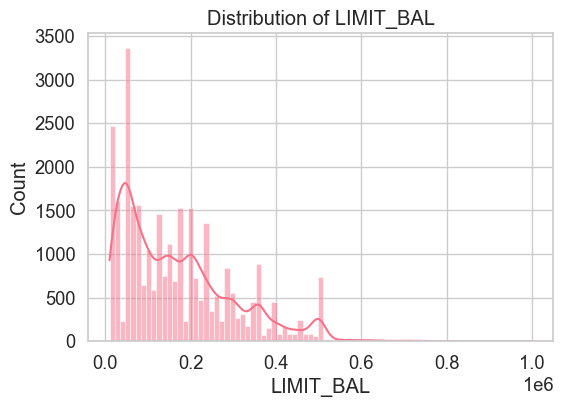

Figure saved to ../outputs/figures/AGE_distribution.png


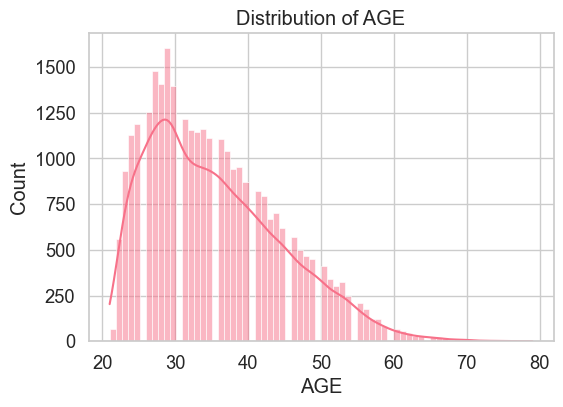

Figure saved to ../outputs/figures/BILL_AMT1_distribution.png


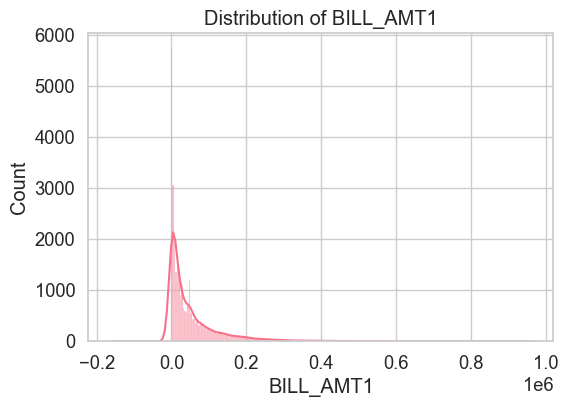

In [393]:
plot_univariate(df, 'LIMIT_BAL', 'LIMIT_BAL_distribution.png')
plot_univariate(df, 'AGE', 'AGE_distribution.png')
plot_univariate(df, 'BILL_AMT1', 'BILL_AMT1_distribution.png')

LIMIT_BAL and BILL_AMT1 are right-skewed; AGE has a near-normal distribution with a peak in late 20s to early 30s.

## 3. Bivariate Analysis
Explore relationships between features and the target variable.


Figure saved to ../outputs/figures/LIMIT_BAL_vs_default_payment.png


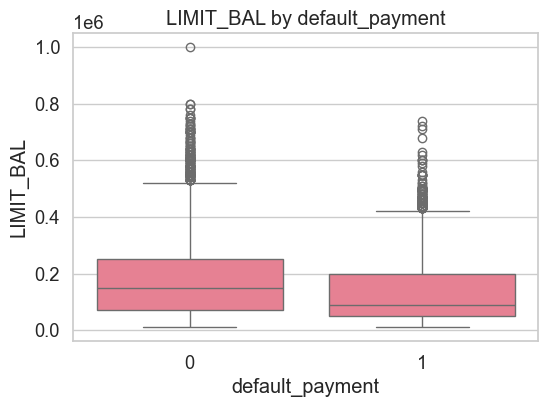

Figure saved to ../outputs/figures/AGE_vs_default_payment.png


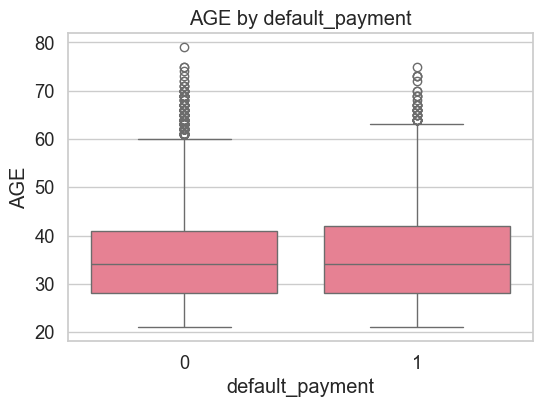

In [394]:
plot_bivariate(df, 'LIMIT_BAL', 'default_payment', 'LIMIT_BAL_vs_default_payment.png')
plot_bivariate(df, 'AGE', 'default_payment', 'AGE_vs_default_payment.png')

Default rate tends to be slightly higher in lower LIMIT_BAL segments and younger age groups.

## 4. Correlation Analysis
Visualize the correlation matrix for all features.


Figure saved to ../outputs/figures/correlation_matrix.png


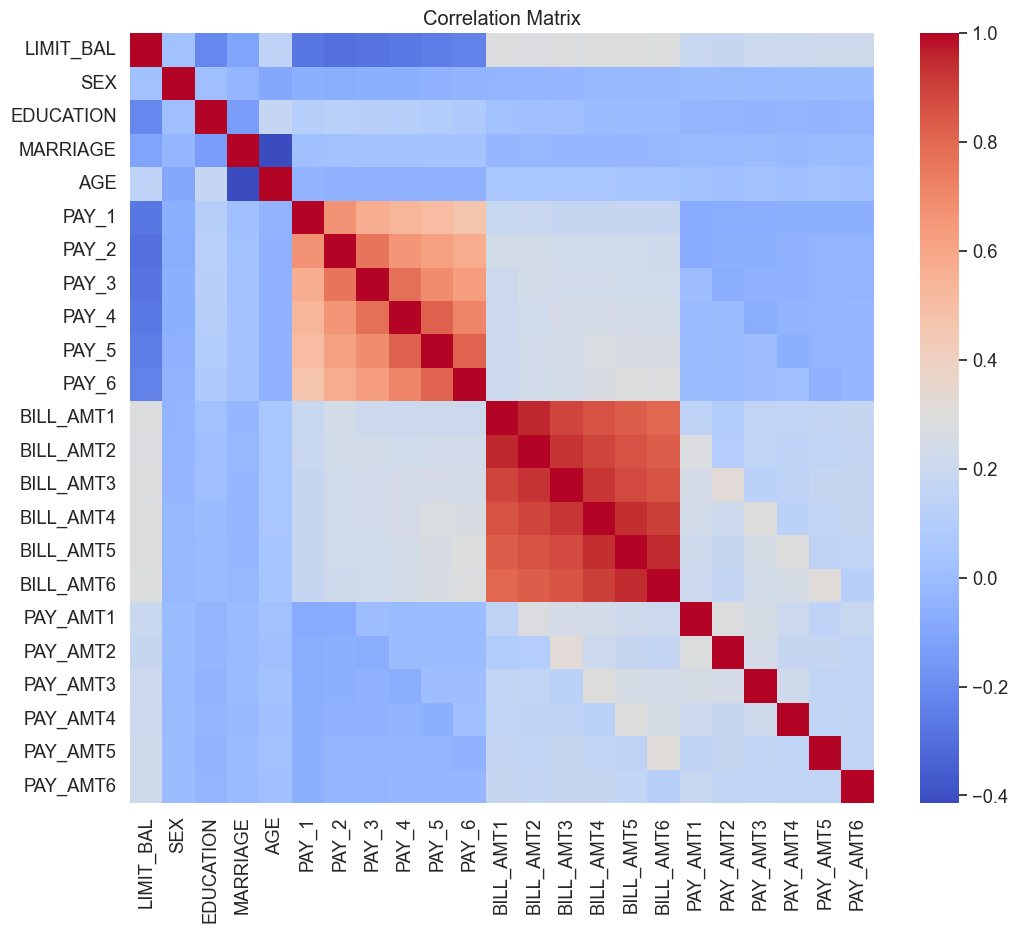

In [395]:
plot_correlation_matrix(df.drop(columns=['default_payment']), 'correlation_matrix.png')

Strong positive correlation among bill amounts and payment amounts over time.

## 5. Outlier analysis



Figure saved to ../outputs/figures/outliers.png


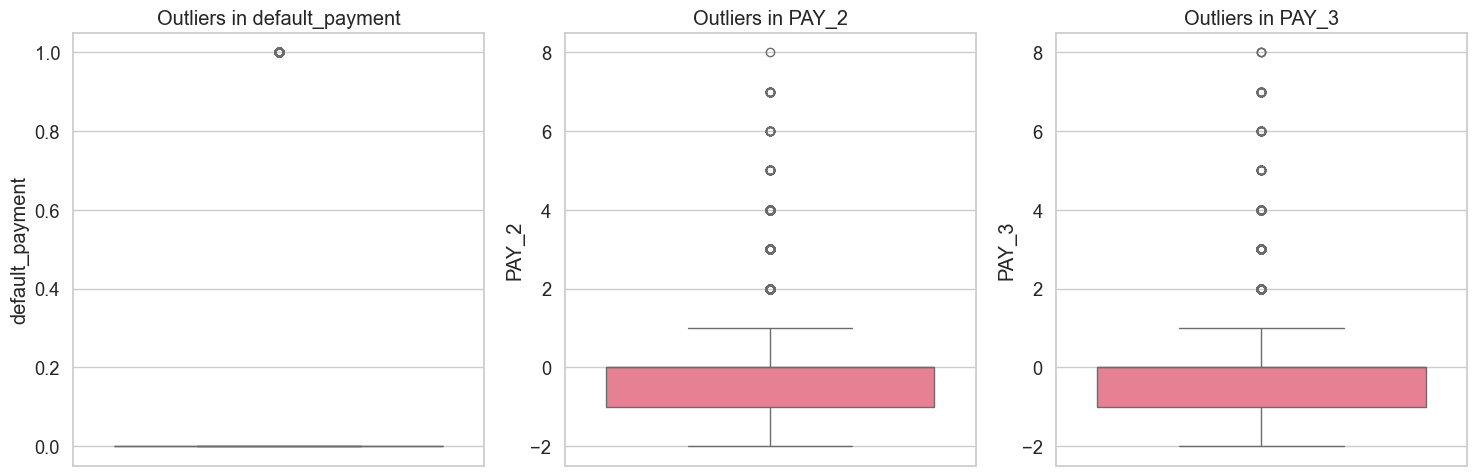

In [396]:
# Analyze outliers in the dataset
outlier_df = analyze_outliers(df, n_top_outliers=3, filename='outliers.png')

Features like default, PAY_2, PAY_3, and BILL_AMT series contain heavy outliers that need treatment.

In [397]:
cols_to_cap = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
               'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
               'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

for col in cols_to_cap:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    df[col] = df[col].clip(lower=lower, upper=upper)

Capped high-impact outliers while retaining the full dataset.

## 6. Data Cleaning

### Fixing Categorical Labels

In [398]:
df['MARRIAGE'].value_counts()

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64

Figure saved to ../outputs/figures/MARRIAGE_distribution.png


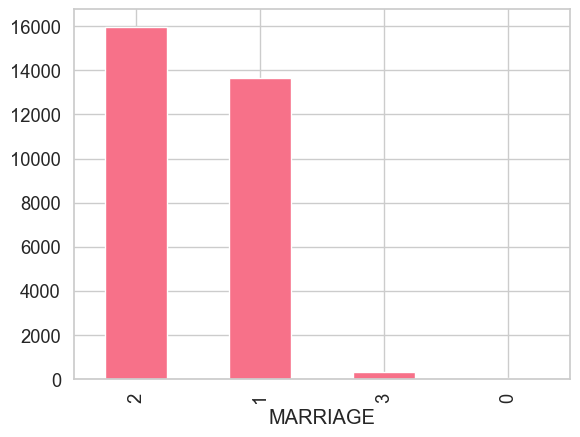

In [399]:
df.MARRIAGE.value_counts().plot(kind = 'bar')
save_figures(plt.gcf(), 'MARRIAGE_distribution.png')

In [400]:
# MARRIAGE values: Replace 0 with 3 (assumed as others)
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3

In [401]:
df.SEX.value_counts()

SEX
2    18112
1    11888
Name: count, dtype: int64

In [402]:
df.EDUCATION.value_counts()

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

Figure saved to ../outputs/figures/EDUCATION_distribution.png


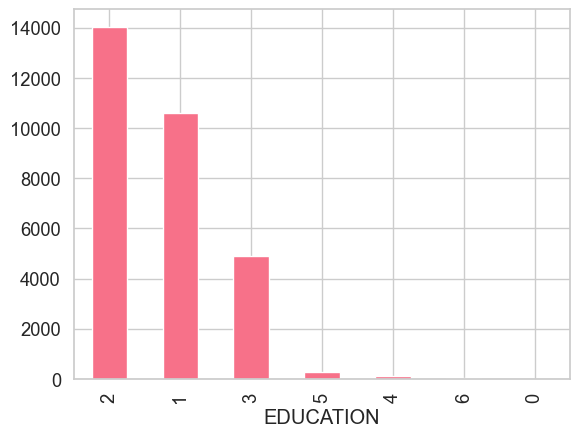

In [403]:
df.EDUCATION.value_counts().plot(kind = "bar")
save_figures(plt.gcf(), 'EDUCATION_distribution.png')

In [404]:
# EDUCATION values: Group 0, 5, 6 into 4 (others)
df.loc[df.EDUCATION.isin([0, 5, 6]), 'EDUCATION'] = 4

### Numerical variables

Figure saved to ../outputs/figures/Bills_distribution.png


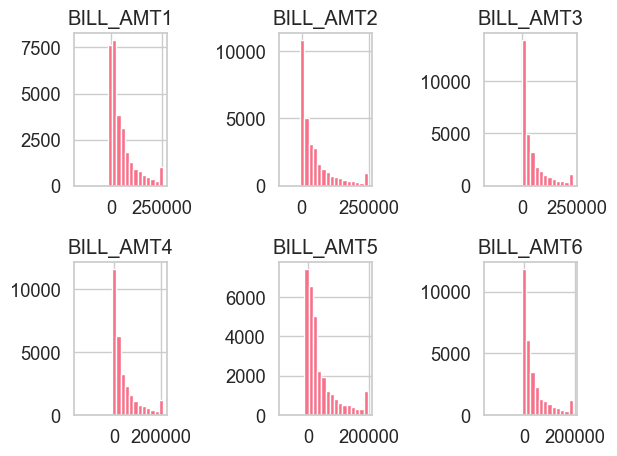

In [405]:
bills = df[['BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']]
draw_histograms(bills, bills.columns, 2, 3, 20, 'Bills_distribution.png')

Figure saved to ../outputs/figures/PAY_AMT_distribution.png


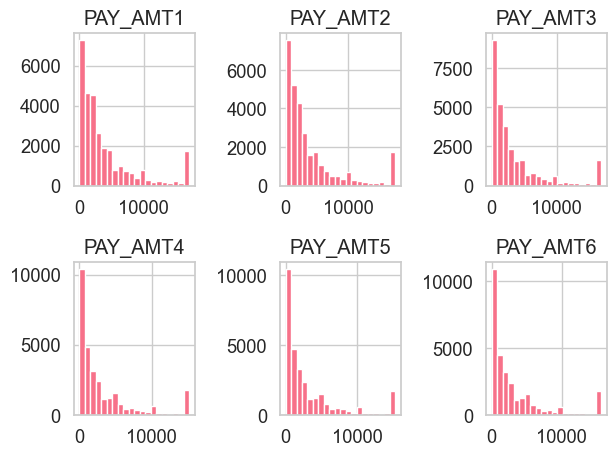

In [406]:
pay = df[['PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
draw_histograms(pay, pay.columns, 2, 3, 20, 'PAY_AMT_distribution.png')

Figure saved to ../outputs/figures/LATE_PAYMENTS_distribution.png


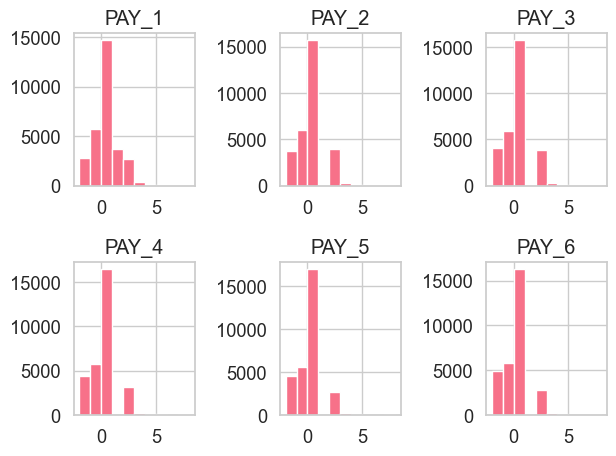

In [407]:
late = df[['PAY_1','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]
draw_histograms(late, late.columns, 2, 3, 10, 'LATE_PAYMENTS_distribution.png')

Figure saved to ../outputs/figures/LIMIT_BAL_distribution.png


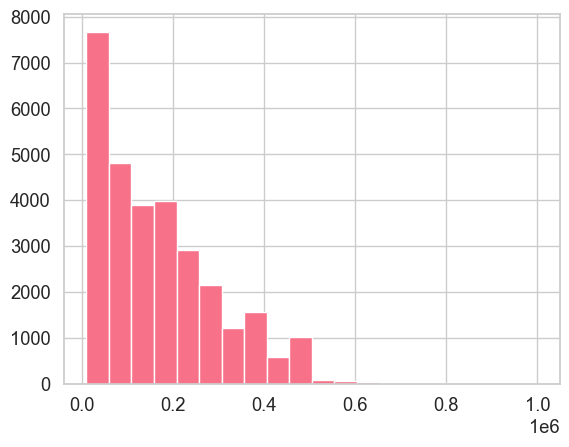

In [408]:
df.LIMIT_BAL.hist(bins = 20)
save_figures(plt.gcf(), 'LIMIT_BAL_distribution.png')

## 7. Feature Engineering

#### PAY_X Normalization

In [409]:
# PAY_X Normalization (turn -1, -2, 0 → 0; all positives → 1)
for i in range(1, 7):
    df[f'PAY_{i}'] = df[f'PAY_{i}'].apply(lambda x: 1 if x > 0 else 0)

#### Combined SEX & MARRIAGE

In [410]:
df.groupby(['SEX', 'default_payment']).size()

SEX  default_payment
1    0                   9015
     1                   2873
2    0                  14349
     1                   3763
dtype: int64

In [411]:
gender = df.groupby(['SEX', 'default_payment']).size().unstack(1)

In [412]:
pd.crosstab(df.SEX, df.default_payment)

default_payment,0,1
SEX,,
1,9015,2873
2,14349,3763


Figure saved to ../outputs/figures/gender_plot.png


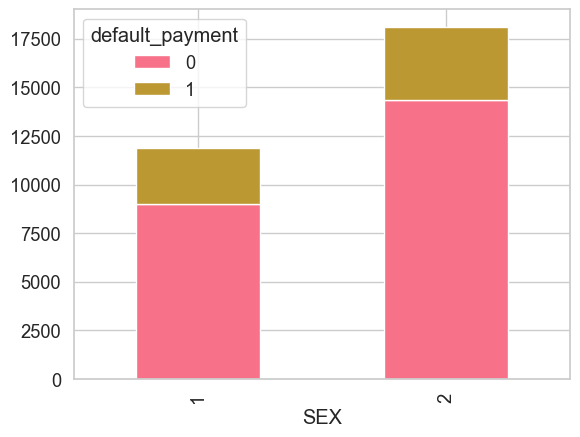

In [413]:
gender.plot(kind='bar', stacked = True)
save_figures(plt.gcf(), 'gender_plot.png')

In [414]:
gender['perc'] = (gender[1]/(gender[0] + gender[1])) 

In [415]:
gender

default_payment,0,1,perc
SEX,,,
1,9015,2873,0.241672
2,14349,3763,0.207763


In [416]:
df['SE_MA'] = df.SEX * df.MARRIAGE

#### Age Grouping + Combined Features

Figure saved to ../outputs/figures/AgeBin_distribution.png


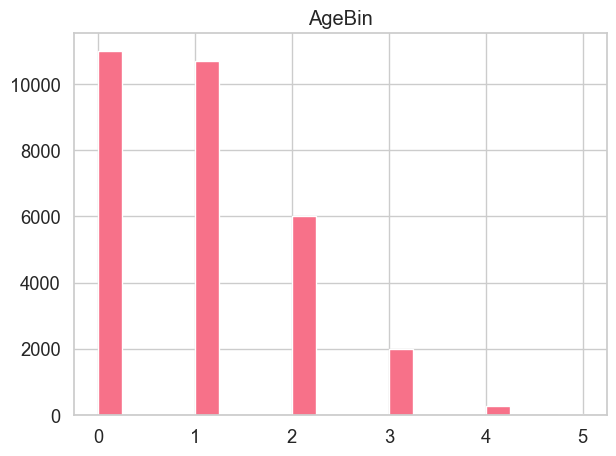

In [417]:
df['AgeBin'] = pd.cut(df['AGE'], bins=[20, 30, 40, 50, 60, 70, 81], labels=False)
draw_histograms(df, ['AgeBin'], 1, 1, 20, 'AgeBin_distribution.png')

In [418]:
df['SE_AG'] = df['SEX'] * 5 + df['AgeBin'].fillna(0).astype(int)

## 8. Behavioral Features

#### Clients with no activity

In [419]:
for i in range(1, 7):
    df[f'Client_{i}'] = 1
    condition = (df[f'PAY_{i}'] == 0) & (df[f'BILL_AMT{i}'] == 0) & (df[f'PAY_AMT{i}'] == 0)
    df.loc[condition, f'Client_{i}'] = 0

#### Average Expenditure Trend

In [420]:
for i in range(5, 0, -1):
    df[f'Avg_exp_{6-i}'] = sum(
        df[f'BILL_AMT{j}'] - (df[f'BILL_AMT{j+1}'] - df[f'PAY_AMT{j}'])
        for j in range(6-i, 6)
    ) / i

#### Closeness to Limit

In [421]:
for i in range(1, 7):
    df[f'Closeness_{i}'] = (df['LIMIT_BAL'] - df[f'BILL_AMT{i}']) / df['LIMIT_BAL']

 These behavioral indicators give insight into customer repayment behavior and credit utilization, which are valuable for prediction models.

In [422]:
payment_status_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

In [423]:
df['Avg_Payment_Delay'] = df[payment_status_cols].replace(-1, 0).mean(axis=1)
df['Max_Payment_Delay'] = df[payment_status_cols].max(axis=1)
df['Times_Delayed'] = (df[payment_status_cols] > 0).sum(axis=1)

In [424]:
df['Consistent_Delays'] = 0
for i in range(len(payment_status_cols) - 1):
    df['Consistent_Delays'] += ((df[payment_status_cols[i]] > 0) & (df[payment_status_cols[i+1]] > 0)).astype(int)

In [425]:
df['Recent_Delay'] = df['PAY_1']

In [426]:
df['Avg_Bill'] = df[bill_cols].mean(axis=1)
df['Avg_Payment'] = df[payment_status_cols].mean(axis=1)
df['Payment_Ratio_Last_Month'] = df['PAY_AMT1'] / (df['BILL_AMT1'] + 1e-6)
df['Total_Bill_vs_Payment_Ratio'] = df[payment_status_cols].sum(axis=1) / (df[bill_cols].sum(axis=1) + 1e-6)

In [427]:
# Utilization trend (slope of bill amounts)
bill_series = df[bill_cols].values
df['Utilization_Trend'] = [np.polyfit(range(6), bill_series[i], 1)[0] for i in range(len(df))]

In [428]:
# Ever fully paid
df['Ever_Fully_Paid'] = 0
for pay_col, bill_col in zip(payment_status_cols, bill_cols):
    df['Ever_Fully_Paid'] = df['Ever_Fully_Paid'] | (df[pay_col] >= df[bill_col])
df['Ever_Fully_Paid'] = df['Ever_Fully_Paid'].astype(int)

In [429]:
# Ever underpaid
df['Ever_Underpaid'] = 0
for pay_col, bill_col in zip(payment_status_cols, bill_cols):
    df['Ever_Underpaid'] = df['Ever_Underpaid'] | (df[pay_col] < df[bill_col])
df['Ever_Underpaid'] = df['Ever_Underpaid'].astype(int)

In [430]:
# Age and Credit interaction
df['Age_Credit_Interaction'] = df['AGE'] * df['LIMIT_BAL']

In [431]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,Consistent_Delays,Recent_Delay,Avg_Bill,Avg_Payment,Payment_Ratio_Last_Month,Total_Bill_vs_Payment_Ratio,Utilization_Trend,Ever_Fully_Paid,Ever_Underpaid,Age_Credit_Interaction
0,20000,2,2,1,24,1,1,0,0,0,...,1,1,1284.000000,0.333333,0.000000,0.000260,-844.571429,1,1,480000
1,120000,2,2,2,26,0,1,0,0,0,...,0,0,2846.166667,0.333333,0.000000,0.000117,247.857143,0,1,3120000
2,90000,2,2,2,34,0,0,0,0,0,...,0,0,16942.166667,0.000000,0.051917,0.000000,-1854.714286,0,1,3060000
3,50000,2,2,1,37,0,0,0,0,0,...,0,0,38555.666667,0.000000,0.042562,0.000000,-4743.257143,0,1,1850000
4,50000,1,2,1,57,0,0,0,0,0,...,0,0,18223.166667,0.000000,0.232099,0.000000,2231.514286,0,1,2850000


In [432]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_payment', 'SE_MA', 'AgeBin', 'SE_AG', 'Client_1', 'Client_2',
       'Client_3', 'Client_4', 'Client_5', 'Client_6', 'Avg_exp_1',
       'Avg_exp_2', 'Avg_exp_3', 'Avg_exp_4', 'Avg_exp_5', 'Closeness_1',
       'Closeness_2', 'Closeness_3', 'Closeness_4', 'Closeness_5',
       'Closeness_6', 'Avg_Payment_Delay', 'Max_Payment_Delay',
       'Times_Delayed', 'Consistent_Delays', 'Recent_Delay', 'Avg_Bill',
       'Avg_Payment', 'Payment_Ratio_Last_Month',
       'Total_Bill_vs_Payment_Ratio', 'Utilization_Trend', 'Ever_Fully_Paid',
       'Ever_Underpaid', 'Age_Credit_Interaction'],
      dtype='object')

In [433]:
df.to_csv('../data/processed/credit_card_default_processed.csv', index=False)